## Mixed-Curvature SNE

In [177]:
import numpy as np
import matplotlib.pyplot as plt

import tsne
from htsne_impl import TSNE as hTSNE
from vmfsne_impl import TSNE as vmfSNE
from cosne import *

from product_space_wrapped_normal import ProductSpace
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

### Re-create t-SNE visualization on MNIST

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


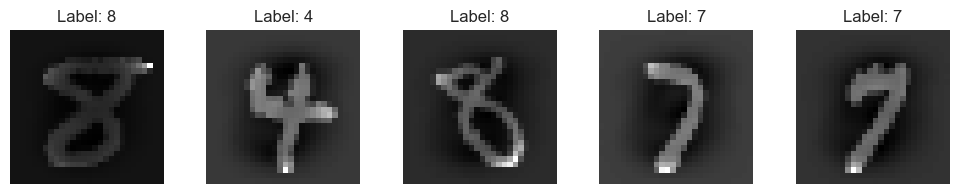

In [181]:
"""
Data preprocessing pipeline for MNIST dataset:
1. Loads MNIST as initial benchmark dataset (consistent with original t-SNE paper)
2. Applies StandardScaler to normalize features (important for distance calculations)
3. Includes visualization check for data integrity

Key Features:
- Configurable sample size for development/testing
- Reproducible sampling with random_state
- Float32 conversion for computational efficiency

This implementation serves as our baseline dataset before moving to more complex
hierarchical and network data structures mentioned in the proposal.
"""

def load_mnist(n_samples=1000, random_state=42):
    """
    Load and preprocess MNIST dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples to load
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input data
    y : array of shape (n_samples,)
        The labels
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [251]:
tsne_model = tsne.TSNE(n_components=2, perplexity=30, early_exaggeration=20.0, learning_rate=200.0, random_state=3)
X_tsne = tsne_model.fit_transform(X_mnist)

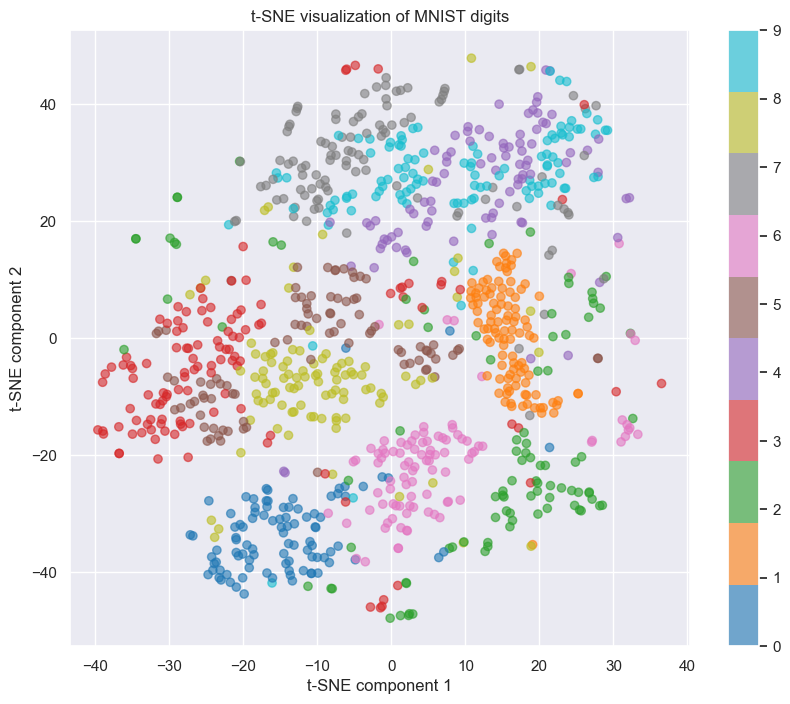

In [252]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                        c=y_mnist.astype(int),
                        cmap='tab10',
                        alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of MNIST digits')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

### Re-create CO-SNE visualization on synthetic point clusters

embs torch.Size([100, 5])


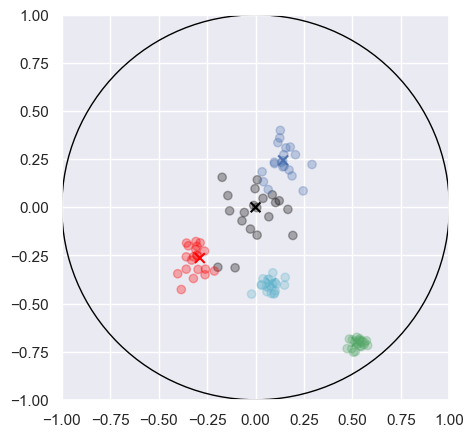

In [93]:
embeddings, colors = generate_high_dims()

In [94]:
dists = pmath.dist_matrix(embeddings, embeddings, c=1).numpy()

In [95]:
cosne = hTSNE(
    n_components=2,
    verbose=0,
    method='exact',
    square_distances=True,
    metric='precomputed',
    learning_rate_for_h_loss=0.1,
    student_t_gamma=0.1,
    learning_rate=5.0,
    n_iter=1000,
    perplexity=20,
    early_exaggeration=1.0,
)
COSNE_embedding = cosne.fit_transform(dists, embeddings)

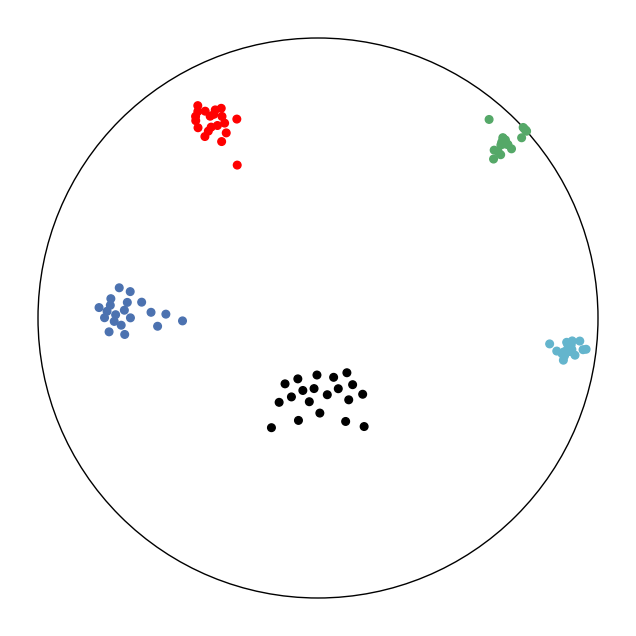

In [96]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
plt.gca().add_patch(circle1)

plt.scatter(COSNE_embedding[:,0], COSNE_embedding[:,1], c=colors, s=30)
ax.set_aspect('equal')
plt.axis('off')

plt.savefig("./saved_figures/" + "CO-SNE.png", bbox_inches='tight', dpi=fig.dpi)
plt.show()

### CO-SNE visualization with hyperbolic data from wrapped normal distribution

In [173]:
hyp_wrapped = ProductSpace(signature=[(5, -1.0)])
hyp_wrapped.sample_clusters(
    num_points=100,
    num_classes=5,
    cov_scale=0.0015,
    # centers=[[ 0.1000,  0.0000,  0.0000,  0.0000,  0.0000],
    #     [ 0.0000, -0.2000,  0.0000,  0.0000,  0.0000],
    #     [ 0.0000,  0.0000,  0.9000,  0.0000,  0.0000],
    #     [ 0.0000,  0.0000,  0.0000, -0.9000,  0.0000],
    #     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
    sigma=0.25      # standard deviation of cluster means
)
X_hyp = hyp_wrapped.X[:,1:]     # remove timelike dimension
y_hyp = hyp_wrapped.y

In [174]:
X_hyp_tensor = torch.tensor(X_hyp, dtype=torch.float32)
dists_hyp = pmath.dist_matrix(X_hyp_tensor, X_hyp_tensor, c=1).numpy()

In [175]:
cosne = hTSNE(
    n_components=2,
    verbose=0,
    method='exact',
    square_distances=True,
    metric='precomputed',
    learning_rate_for_h_loss=0.1,
    student_t_gamma=0.1,
    learning_rate=5.0,
    n_iter=1000,
    perplexity=20,
    early_exaggeration=1.0,
)
X_embedding = cosne.fit_transform(dists_hyp, X_hyp_tensor)

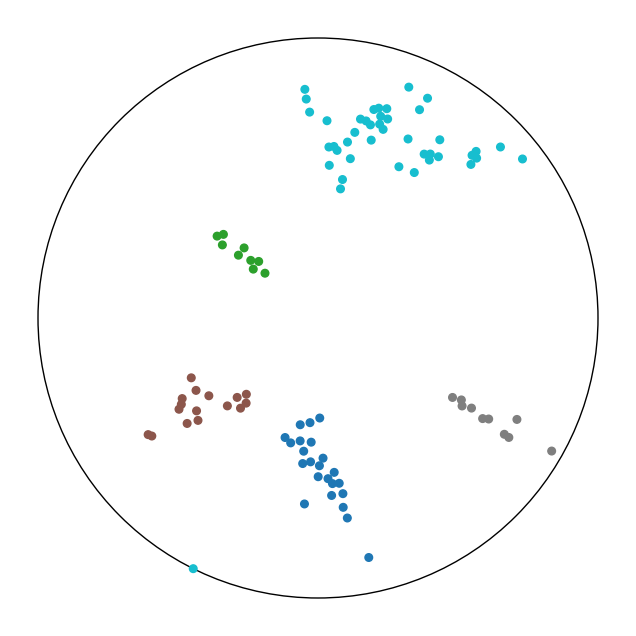

In [176]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

circle2 = plt.Circle((0, 0), 1, color='black', fill=False)
plt.gca().add_patch(circle2)

plt.scatter(X_embedding[:,0], X_embedding[:,1], c=y_hyp, cmap='tab10', s=30)
ax.set_aspect('equal')
plt.axis('off')

plt.savefig("./saved_figures/" + "CO-SNE_wrapped.png", bbox_inches='tight', dpi=fig.dpi)
plt.show()

### Create hyperspherical data from wrapped normal distribution [DOES NOT CONVERGE]

In [14]:
sph_wrapped = ProductSpace(signature=[(5, 1.0)])
sph_wrapped.sample_clusters(
    num_points=100,
    num_classes=5,
    cov_scale=0.3
)
X_sph = sph_wrapped.X[:,1:]
y_sph = sph_wrapped.y

In [15]:
vmfsne = vmfSNE(
    n_components=2,
    verbose=0,
    method='exact',
    learning_rate=20.0,
    max_iter=1000,
    perplexity=30.0,
    early_exaggeration=1.0,
    kappa=1.0
)
# X_embedding = vmfsne.fit_transform(X_sph)

### Product space from wrapped normal distribution with t-SNE visualization

In [82]:
ps = ProductSpace(signature=[(5, -1.), (5, 1.), (5, 0.)], seed=None)
ps.sample_clusters(1000, 5, cov_scale=0.3, sigma=1.0)

In [83]:
tsne_model = tsne.TSNE(n_components=2,
                       perplexity=30,
                       random_state=42)
ps_X_tsne = tsne_model.fit_transform(ps.X)

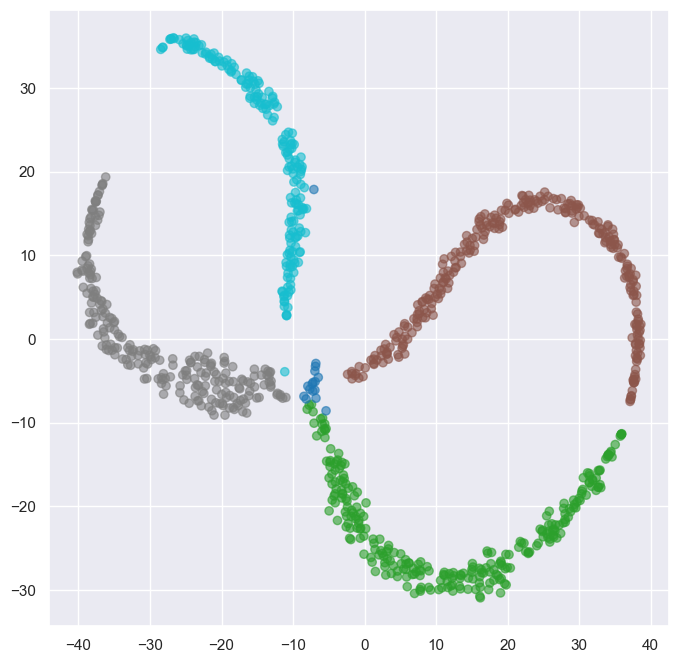

In [84]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(ps_X_tsne[:, 0], ps_X_tsne[:, 1],
                        c=ps.y.astype(int),
                        cmap='tab10',
                        alpha=0.6)
plt.savefig("./saved_figures/" + "t-SNE_ps.png", bbox_inches='tight', dpi=fig.dpi)
plt.show()

### Product space from wrapped normal distribution and CO-SNE visualization

In [85]:
ps_tensor = torch.tensor(ps.X, dtype=torch.float32)
dists_ps = pmath.dist_matrix(ps_tensor, ps_tensor, c=1).numpy()

In [86]:
cosne = hTSNE(
    n_components=2,
    verbose=0,
    method='exact',
    square_distances=True,
    metric='precomputed',
    learning_rate_for_h_loss=0.1,
    student_t_gamma=0.1,
    learning_rate=5.0,
    n_iter=1000,
    perplexity=20,
    early_exaggeration=1.0,
)
ps_X_cosne = cosne.fit_transform(dists_ps, ps_tensor)

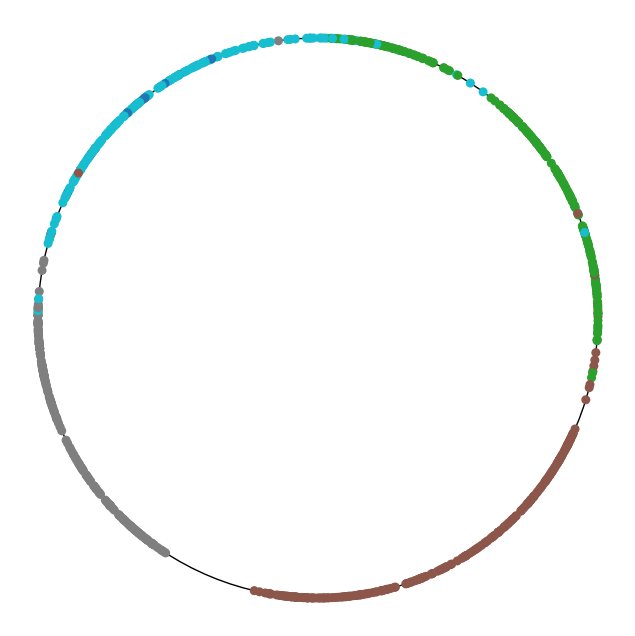

In [87]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

circle2 = plt.Circle((0, 0), 1, color='black', fill=False)
plt.gca().add_patch(circle2)

plt.scatter(ps_X_cosne[:,0], ps_X_cosne[:,1], c=ps.y, cmap='tab10', s=30)
ax.set_aspect('equal')
plt.axis('off')

plt.savefig("./saved_figures/" + "CO-SNE_ps.png", bbox_inches='tight', dpi=fig.dpi)
plt.show()